In [1]:
### Import libraries  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
%matplotlib inline
from datetime import datetime
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from library.sb_utils import save_file
import warnings
plt.rcParams['figure.figsize'] = (10, 7)
plt.style.use('seaborn-colorblind')

In [3]:
df_ny = pd.read_csv('./data/df_ny.csv', index_col='Date', parse_dates=True)
df_ny_org=df_ny[df_ny['type']=='organic']
df_ny_con=df_ny[df_ny['type']=='conventional']
df_ny.head(3)

,AveragePrice,TotalVolume,type,year,region
Date,,,,,
2015-01-04,1.93,17328.24,organic,2015,NewYork
2015-01-04,1.09,1402890.20,conventional,2015,NewYork
2015-01-11,1.34,1018225.83,conventional,2015,NewYork


# visualize time serie 

In [4]:
def visualizing_time_serie(df):
    ax = df[['AveragePrice']].plot(linewidth=2, fontsize=8)
    ax2 = df[['AveragePrice']].resample('M').mean().plot(linewidth=2, fontsize=8);
    ax.set_ylabel('Average Price', fontsize=10)
    ax2.set_ylabel('Average Price', fontsize=10)
    ax.set_title('Average Price from 2015 to 2021', fontsize=12)
    ax2.set_title('Average Price from 2015 to 2021 ', fontsize=12)
    ax3 = df[['TotalVolume']].plot(linewidth=2, fontsize=8)
    ax4 = df[['TotalVolume']].resample('M').mean().plot(linewidth=2, fontsize=8);
    ax3.set_ylabel('Total Volume', fontsize=10)
    ax4.set_ylabel('Total Volume', fontsize=10)
    ax3.set_title(' Total Volume from 2015 to 2021 ', fontsize=12)
    ax4.set_title(' Total Volume from 2015 to 2021', fontsize=12)
    plt.show()
    return ax,ax2,ax3,ax4

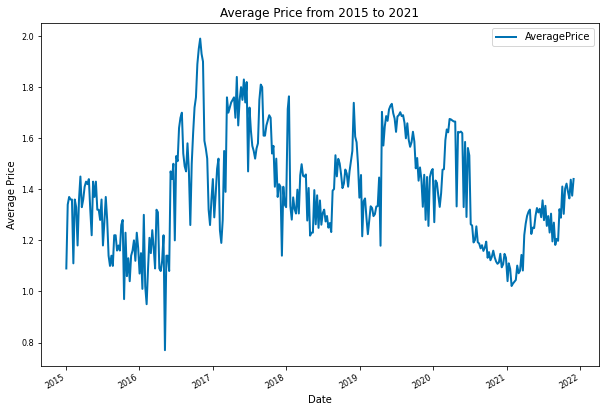

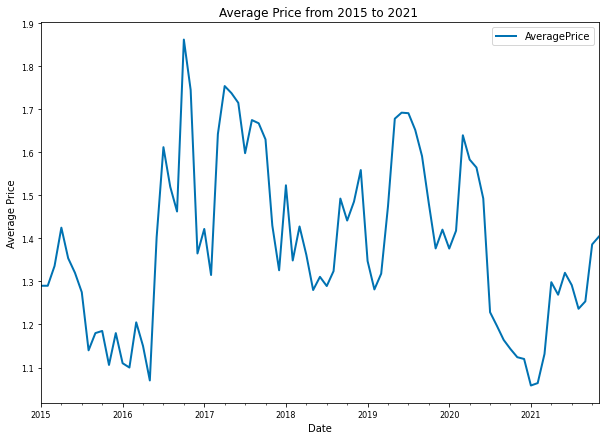

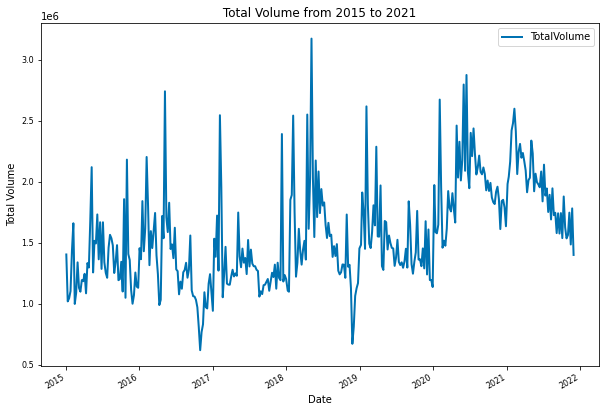

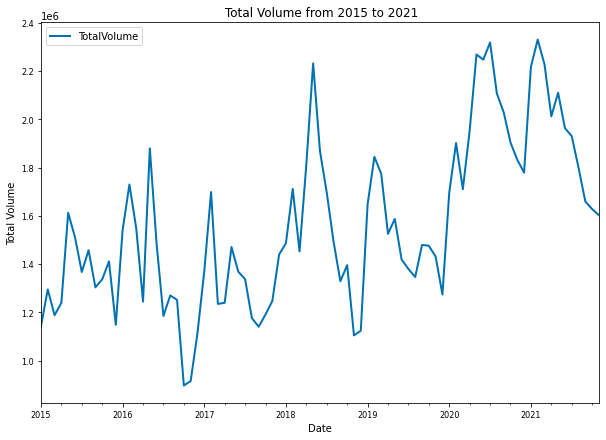

(<AxesSubplot:title={'center':'Average Price from 2015 to 2021'}, xlabel='Date', ylabel='Average Price'>,
 <AxesSubplot:title={'center':'Average Price from 2015 to 2021 '}, xlabel='Date', ylabel='Average Price'>,
 <AxesSubplot:title={'center':' Total Volume from 2015 to 2021 '}, xlabel='Date', ylabel='Total Volume'>,
 <AxesSubplot:title={'center':' Total Volume from 2015 to 2021'}, xlabel='Date', ylabel='Total Volume'>)

In [5]:
# visualize the entire dataset (organic and conventional avocado price and volume)
visualizing_time_serie(df_ny_con)

In [6]:
def visualizing_time_serie_tw(df):
    ax= df['AveragePrice'].resample('M').mean().plot(linewidth=2, fontsize=8,color='blue' );
    ax2 = ax.twinx()
    ax2=df['TotalVolume'].resample('M').mean().plot(linewidth=2, fontsize=8,color='red' );
    ax.set_ylabel('Average Price', fontsize=10)
    ax2.set_ylabel('Total Volume', fontsize=10)
    ax.set_title('Average Price and Total Volume - New York', fontsize=12)
    plt.legend()
    plt.show()
    return ax

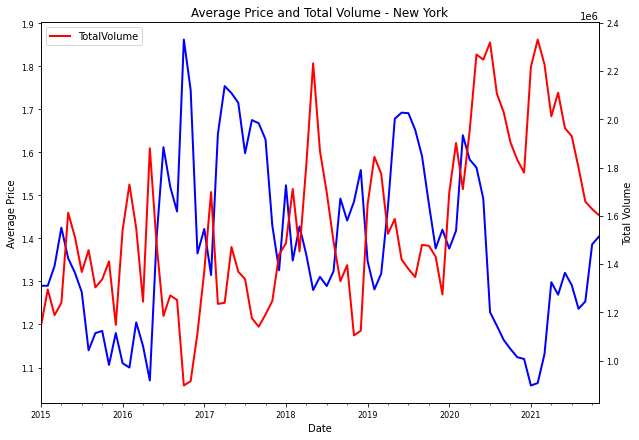

<AxesSubplot:title={'center':'Average Price and Total Volume - New York'}, xlabel='Date', ylabel='Average Price'>

In [7]:
visualizing_time_serie_tw(df_ny_con)

### Check the trend of the time serie with seasonal_decompose from statsmodels.tsa.seasonal

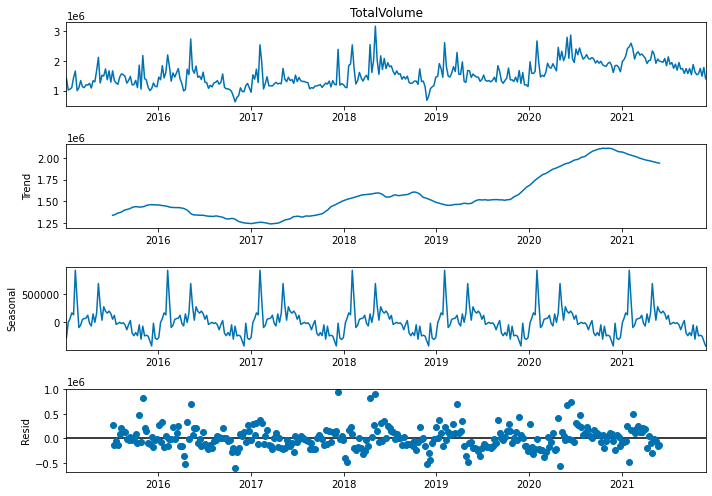

In [8]:
dec = seasonal_decompose(df_ny_con['TotalVolume'],period = 52).plot()
plt.show()

#### smoot the timeserie with resample by month and plot again

In [9]:
#price = seasonal_decompose(df_ny['AveragePrice'].resample('W').mean().dropna(),period = 52).plot()
#vol = seasonal_decompose(df_ny['TotalVolume'].resample('W').mean().dropna(),period = 52).plot()
#plt.show()

Note: the time serie present a seasonal parthern 




# Stationarity of time serie

#### Augmented Dickey-Fuller Test
Augmented Dickey-Fuller Test is a common statistical test used to test whether a given Time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is no stationary. It gives a time-dependent trend.

Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Accept the alternative hypothesis. Time series is stationary.

ADF or t Statistic > critical values: Failed to reject the null hypothesis. The time series is non-stationary

if p-value is not less than .05 (depend on the alpha), we fail to reject the null hypothesis. This means the time series is non-stationary.

Unlike KPSS test, the **null hypothesis  is the series is  stationary**. Based upon the significance level of 0.05 and the p-value of KPSS test, if if P < 0.05 , there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test. otherwise, the serie is stationary. 

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting.

In [10]:
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

In [11]:
for name, column in df_ny_con[['AveragePrice','TotalVolume']].iteritems():
    adfuller_test(column, name=column.name)

 AveragePrice : P-Value = 0.004 => Stationary. 
 TotalVolume : P-Value = 0.0 => Stationary. 


In [12]:
def kpss_test(series, sig=0.05, name=''):
    statistic, p_value, n_lags, critical_values = kpss(series, nlags='auto')    
    p_value = round(p_value, 3) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Non Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => stationary.")

In [13]:
for name, column in df_ny_con[['AveragePrice','TotalVolume']].iteritems():
    kpss_test(column, name=column.name)

 AveragePrice : P-Value = 0.1 => stationary.
 TotalVolume : P-Value = 0.01 => Non Stationary. 


C:\Users\mirei\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\mirei\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


###  find the order of the AR term (p) -pacf /find the order of the MA term (q)-acf

For different types of models we expect the following behavior in the ACF and PACF:

..............AR(p)..................	MA(q).......................	ARMA(p,q)

ACF	.......Tails off	.............Cuts off after lag q...............	Tails off

PACF	....Cuts off after lag p	......Tails off	....................Tails off


In [14]:
def plot_correlations(serie):
    fig, ax = plt.subplots(figsize=(8, 5))
    _ = plot_acf(serie, ax=ax)
    fig, ax = plt.subplots(figsize=(8, 5))
    _ = plot_pacf(serie, ax=ax)

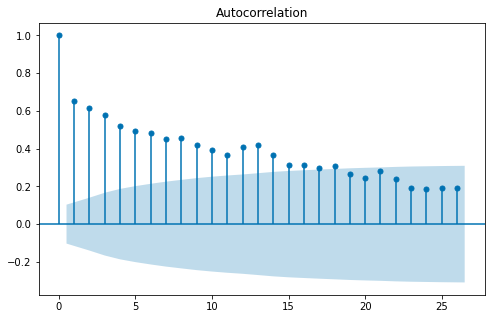

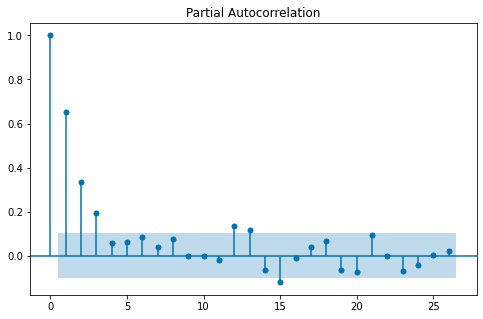

In [15]:
plot_correlations(df_ny_con['TotalVolume']) # AR(9) and MA(0)
#plot_correlations(df_ny['AveragePrice'].diff().dropna())# not need , over diff

## Split the data into a train and test set

In [16]:
# Split the data into a train and test set
def train_test(df):
    train = df.loc[:'2020']
    test = df.loc['2021':]
    return train, test 

def plot_price_vol(train, test, col): # df is train or test
    # Create an axis
    fig, ax = plt.subplots(figsize=(15,8))

    # Plot the train and test sets on the axis ax
    train[[col]].plot(ax=ax)
    test[[col]].plot(ax=ax)
    ax.set_title( col + ' ' + 'train and test set', fontsize=20)
    plt.show()

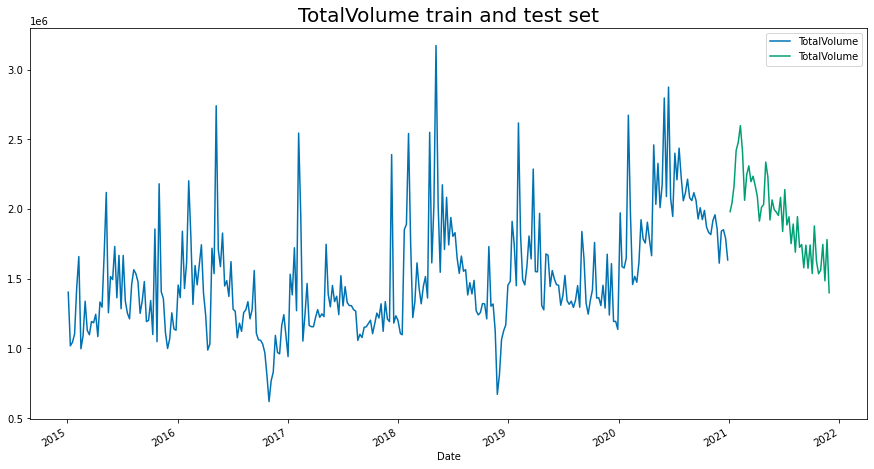

In [17]:
# split data into test and train set
train, test = train_test(df_ny_con)  # daily dataset
# plot the train and test set
plot_price_vol(train, test, 'TotalVolume')

In [18]:
len(df_ny_con), len(train), len(test)

(361, 313, 48)

In [19]:
#resample the dataset , split and plot 
# split data into test and train set

trainm, testm = train_test(df_ny_con.resample('M').mean().dropna()) # monthly dataset

# plot the train and test set
#plot_price_vol(trainm, testm, 'TotalVolume')

In [20]:
len(df_ny_con), len(trainm), len(testm)

(361, 72, 11)

## Evaluate different ARIMA models with several different p, d, and q values - choice of best model according to AIC and BIC

BIC favors simpler models than AIC

Lower the AIC , better the model and lower BIC indicates a better model

AIC is better at Choosing predictive models

BIS is better at choosin good explannatory model

In the context of this project, we will look for lower AIC --- for best predictive model

### daily dataset

In [21]:
#find_order(train,'AveragePrice', p, q, d) # function to review

In [22]:
import warnings
warnings.filterwarnings("ignore")
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values 
for p in range(0,9):
  # Loop over q values 
    for q in range(0,2):
         # Loop over d values 
        for d in range(0,1): 
            try:
            # create and fit ARMA(p,q) model
                model = SARIMAX(train[['TotalVolume']], order=(p,d,q))
                results = model.fit()    
            # Append order and results tuple
                order_aic_bic.append((p,q,d, results.aic, results.bic))
            except:
                print(p, q, None, None)
                #continue
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q','d', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head(2)
# Print order_df in order of increasing AIC
#order_df.sort_values('AIC').head(2)

,p,q,d,AIC,BIC
9,4,1,0,8804.983773,8827.460992
3,1,1,0,8805.987488,8817.226097


In [23]:
### Montly dataset

In [24]:
import warnings
warnings.filterwarnings("ignore")
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values 
for p in range(0,9):
  # Loop over q values 
    for q in range(0,2):
         # Loop over d values 
        for d in range(0,1): 
            try:
            # create and fit ARMA(p,q) model
                model = SARIMAX(trainm[['TotalVolume']], order=(p,d,q))
                results = model.fit()    
            # Append order and results tuple
                order_aic_bic.append((p,q,d, results.aic, results.bic))
            except:
                print(p, q, None, None)
                #continue
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q','d', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head(2)
# Print order_df in order of increasing AIC
#order_df.sort_values('AIC').head(2)(2)

,p,q,d,AIC,BIC
16,8,0,0,1984.234128,2004.724123
6,3,0,0,1984.997284,1994.103949


# Model_1   AR(8)  - Monthly dataset

In [25]:
def sarimax_fit_plot_sum_origin_pred(train, col, p,d,q):
    # Fit model
    model_1 = SARIMAX(train[[col]], 
                      order=(p,d,q), 
                      trend='c')
    results_1 = model_1.fit()
    mae = np.mean(np.abs(results_1.resid)) # mean absolute error from residuals
    Summary= results_1.summary()
    # Make plot of time series for comparison #  four plots, shows us the distribution of the residuals
    Diagnostic = results_1.plot_diagnostics()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,7))  
    tr = trainm[col].plot(ax=ax)
    pred = results_1.predict().plot(ax=ax, color = 'red')#model_ny_con_fit
    
    plt.show()
    
    return Diagnostic, mae, Summary, tr, pred

In [26]:
def sarimax_fit_plot_sum(trainm, col, p,d,q):
    # Fit model
    model_1 = SARIMAX(trainm[[col]], 
                      order=(p,d,q), 
                      trend='c')
    results_1 = model_1.fit()
    mae = np.mean(np.abs(results_1.resid)) # mean absolute error from residuals
    Summary= results_1.summary()
    # Make plot of time series for comparison #  four plots, shows us the distribution of the residuals
    Diagnostic = results_1.plot_diagnostics()
    plt.show()
    return Diagnostic, results_1, mae, Summary

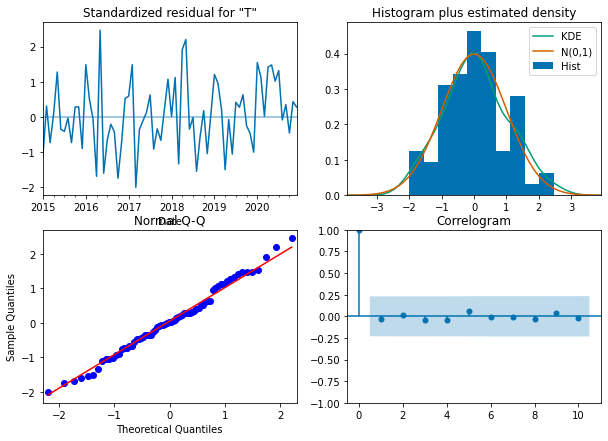

In [27]:
Diagnostic, results_1, mae, Summary = sarimax_fit_plot_sum(trainm, 'TotalVolume', 8,0,0)

In [28]:
results_1

form the summary table 

Prob(Q) is the p-value associated with the null hypothesis that the residuals have no correlation structure.

Prob(JB) is the p-value associated with the null hypothesis that the residuals are Guassian normally distributed. 

If either p-value is less than 0.05 we reject that hypothesis.

Note: the p-value of Prob(JB) is not less than 0.05 , mean that the residuals are Guassian normally distributed.
We have to dick more and expect the model with the seasonal part 

In [29]:
def sarimax_plot_origin_pred(trainm, col, p, d, q): # work with monthly and daily
    model_1 = SARIMAX(trainm[[col]],order=(p,d,q), trend='c')
    results_1 = model_1.fit()
    #Visualize the original dataset plotted against our model.
    fig, ax = plt.subplots(figsize=(10,7))  
    tr = trainm[col].plot(ax=ax)
    pred = results_1.predict().plot(ax=ax, color = 'red')#model_ny_con_fit
    
    plt.show()
    
    return tr, pred

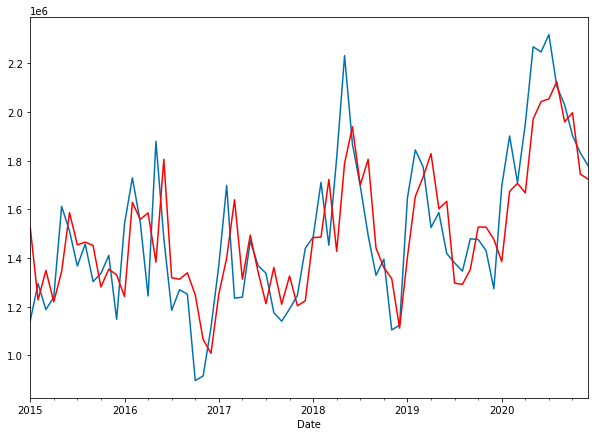

(<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>)

In [30]:
sarimax_plot_origin_pred(trainm, 'TotalVolume', 8, 0, 0)

In [31]:
# plot the test, train, and pred a head data wiht sarimax fucntion, get the pred mean , dates , etc......

def plot_testm_trainm_pred(trainm, testm, col, results, steps=24): # results=model_fit, sarimax 
    # Create forecast object
    forecast_object = results.get_forecast(steps=24)
    # Extract predicted mean attribute
    mean = forecast_object.predicted_mean
    # Calculate the confidence intervals
    conf_int = forecast_object.conf_int()
    # Extract the forecast dates
    dates = mean.index
    # Plot past price test set
    tes = plt.plot(testm.index, testm[col], label='past_test')
    # Plot past price train set
    tr = plt.plot(trainm.index, trainm[col], label='past_train') # add train set
    # Plot the prediction means as line
    pred = plt.plot(dates, mean, label='predicted')
    # Shade between the confidence intervals
    conf = plt.fill_between(dates, conf_int['lower'+' '+ col], conf_int['upper'+ ' '+ col], alpha=0.2)
    # Plot legend and show figure
    plt.legend(loc='upper left')
    plt.show()

    return mean, dates, tes, tr, pred, conf, conf_int

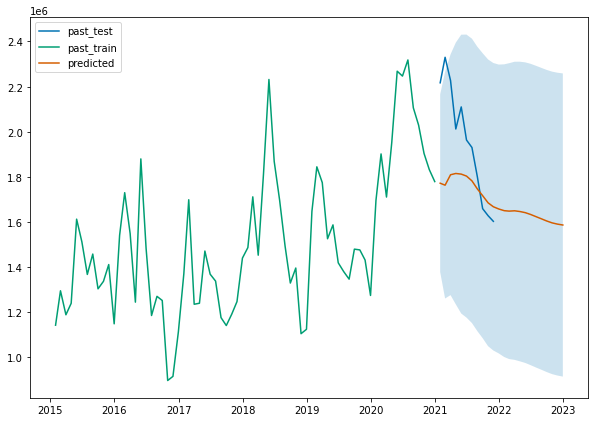

In [32]:
mean, dates, tes, tr, pred, conf, conf_int = plot_testm_trainm_pred(trainm, testm, 'TotalVolume', results_1, steps=24)

In [33]:
mean.to_frame().head(5)

,predicted_mean
2021-01-31,1.771705e+06
2021-02-28,1.762895e+06
2021-03-31,1.809141e+06
2021-04-30,1.814838e+06
2021-05-31,1.812006e+06


In [34]:
conf_int.head(5)

,lower TotalVolume,upper TotalVolume
2021-01-31,1.377615e+06,2.165795e+06
2021-02-28,1.260417e+06,2.265373e+06
2021-03-31,1.275547e+06,2.342736e+06
2021-04-30,1.234655e+06,2.395020e+06
2021-05-31,1.193795e+06,2.430216e+06


## Model Evaluation

In [35]:
# Accuracy metrics-----modify
def forecast_accuracy(forecast, actual):    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1 # 'acf1':acf1 (remove)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [36]:
def get_model_eval(results, testm, col, steps):# len step equal len test size  ( for sarimax)(ok for montly and test )
    # Create forecast object
    forecast_object = results_1.get_forecast(steps=steps) # step the same len as test set 
    # Extract predicted mean attribute
    mean = forecast_object.predicted_mean
    # compute model evaluation 
    evaluation = forecast_accuracy(mean, testm[col].values)
    return evaluation

In [37]:
get_model_eval(results_1, testm, 'TotalVolume', 11)

{'mape': 0.10624450006915988,
 'me': -191532.39541898898,
 'mae': 224116.1650418425,
 'mpe': -0.08623354230205907,
 'rmse': 283305.085505037,
 'corr': 0.7596026839571477,
 'minmax': 0.10588875153864763}

## FORECAST FOR 2022---A wiht dayly dataset 

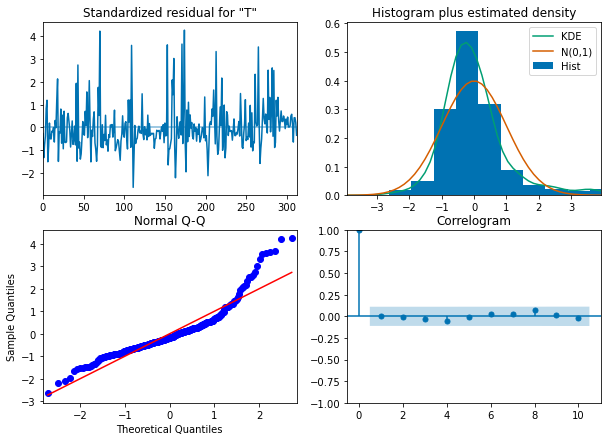

In [38]:
Diagnostic, results_2, mae, Summary = sarimax_fit_plot_sum(train, 'TotalVolume', 4,0,1)

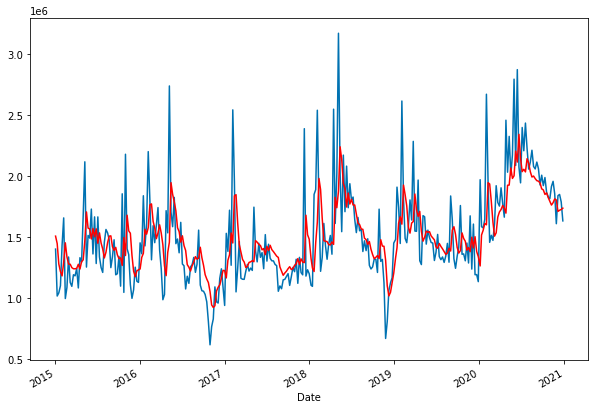

(<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>)

In [39]:
sarimax_plot_origin_pred(train, 'TotalVolume', 4, 0, 1)

In [40]:
len(test)

48

In [41]:
get_model_eval(results_2, test, 'TotalVolume', 48)

{'mape': 0.1624806563683134,
 'me': -329249.8963562679,
 'mae': 338152.62159014464,
 'mpe': -0.15626313886636636,
 'rmse': 394048.3926865055,
 'corr': 0.7932116632021867,
 'minmax': 0.16226338010502384}

In [42]:
def forecast_day(train, test, results, col, steps, index=0 ):   #steps=365, 0 = inforecast, -1=outforecast
    # Create forecast object
    forecast_object = results.get_forecast(steps=steps)
    # Extract predicted mean attribute
    mean = forecast_object.predicted_mean.to_list() #.to_frame()
    # dates ranges (out of test date range)
    forecast_period = steps
    date_range = pd.date_range(test.index[index], periods = forecast_period).strftime("%Y-%m-%d").tolist() #   freq='MS'
    day_to_forcast = pd.DataFrame(date_range, columns=['day'])
    day_to_forcast['day']= pd.to_datetime(day_to_forcast['day'])
    day_to_forcast.set_index('day', inplace=True)
    day_to_forcast['Prediction'] = mean
    
    # Plot
    fig, ax = plt.subplots(figsize=(10,7))
    tr=train[col].plot(ax=ax, label='training')
    test=test[col].plot(ax=ax, label='actual')
    forday=day_to_forcast['Prediction'].plot(ax=ax, label='prediction')
    plt.legend()
    plt.show()
    plt.savefig('./images/volume_forecasted.png')
    
    return  day_to_forcast, tr, tes, forday

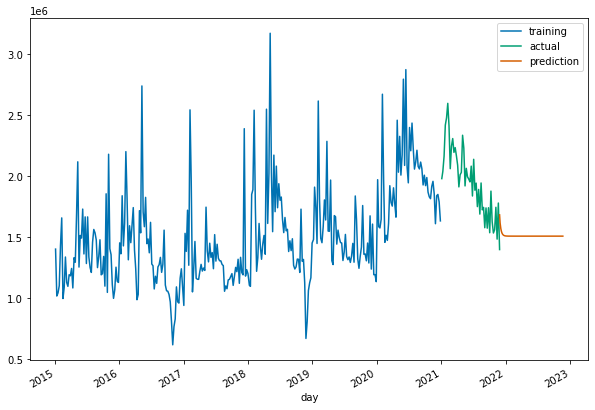

<Figure size 720x504 with 0 Axes>

In [43]:
mean, tr, tes, forday = forecast_day(train, test, results_2, 'TotalVolume', 360, -1)   #steps=365

### Collecting Forcasting dataset for futher analysis 

# model _2    ARMA_order=(4,0,1))  ------ARIMA

In [44]:
def arima_sum_plot_pred(train, test, col, p,d,q, steps):   #steps = 96
    # Build Model  
    model = ARIMA(train[col], order=(p,d,q))  
    results = model.fit(disp=-1) 

    # Forecast
    fc, se, conf = results.forecast(steps, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    fig, ax = plt.subplots(figsize=(10,7),dpi=100 )
    tr=train[col].plot(ax=ax, label='training')
    tes=test[col].plot(ax=ax, label='actual')
    fc=fc_series.plot(ax=ax, label='forecast')
    conf=plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    plt.savefig('./images/Price_predicted.png')

    Summary = results.summary()

    Evaluation = forecast_accuracy(fc_series, test[col])
    
    return Summary, Evaluation, fc_series, results, tr, tes, fc, conf

In [45]:
# dailiy 

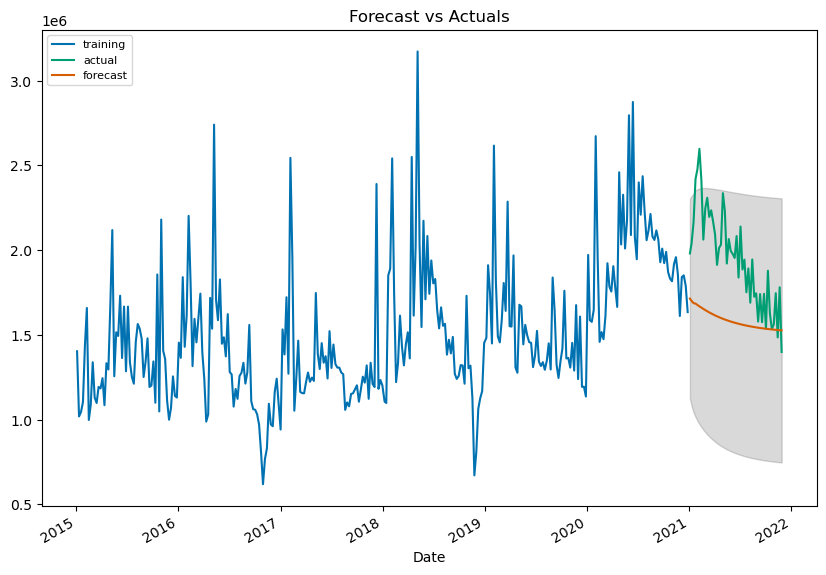

<Figure size 720x504 with 0 Axes>

In [46]:
Summary, Evaluation, fc_series, results_3, tr, tes, fc, conf= arima_sum_plot_pred(train, test, 'TotalVolume', 4, 0, 1, 48)

## FORECAST FOR 2022  --- ARIMA

In [47]:
def arima_forecast_ahead(train, test, col, results, steps, steps2, n): # index = -1 or 0 of test set, steps = 460 steps = 96
    ahead_forcast= results.forecast(steps, alpha=0.05)  # 95% conf ----fc, se, conf the 3 objects from forecast
    fc, se, conf = results.forecast(steps2, alpha=0.05)  # 95% conf (len equal to test len)
    fc_series = pd.Series(fc, index=test.index)
    forecast_period = steps
    date_range = pd.date_range(test.index[n], periods = forecast_period).strftime("%Y-%m-%d").tolist() #   freq='MS'
    day_to_forcast = pd.DataFrame(date_range, columns=['day'])
    day_to_forcast['day']= pd.to_datetime(day_to_forcast['day'])
    day_to_forcast.set_index('day', inplace=True)
    day_to_forcast['Prediction'] = ahead_forcast[0]
    # Plot
    fig, ax = plt.subplots(figsize=(10,7), dpi=100 )
    tr = train[col].plot(ax=ax, label='training')
    tes = test[col].plot(ax=ax, label='actual')
    fcc = fc_series.plot(ax=ax, label='forecast')
    pred = day_to_forcast['Prediction'].plot(ax=ax, label='prediction')
    #test['AveragePrice'].append(day_to_forcast['Prediction']).plot(ax=ax, label='actual')
    plt.title('Actual, predict, forecast')
    plt.legend()
    plt.show()
    plt.savefig('./images/Price_forecasted.png')

    return tr, tes, fcc, pred, day_to_forcast, fc_series

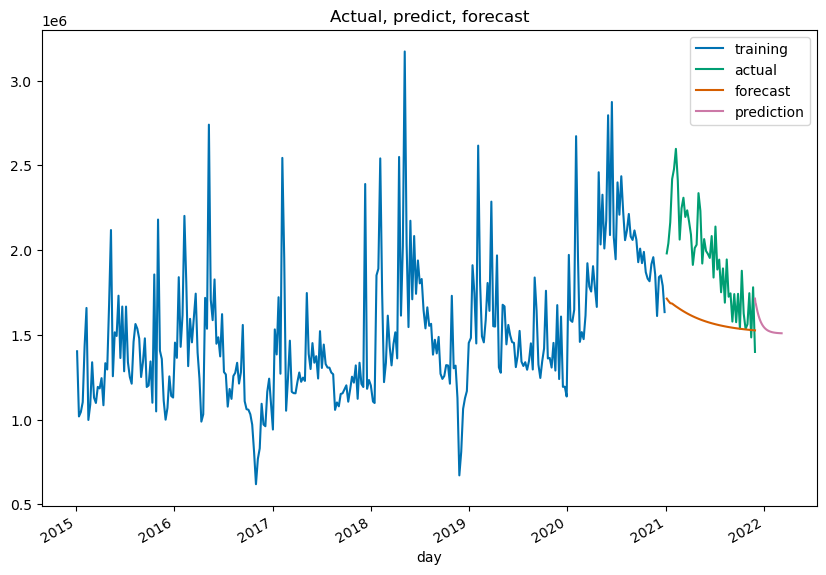

<Figure size 720x504 with 0 Axes>

In [48]:
 tr, tes, fcc, predd, day_to_forcastt, fc_serie  = arima_forecast_ahead(train, test, 'TotalVolume', results_3, 100, 48, -1)

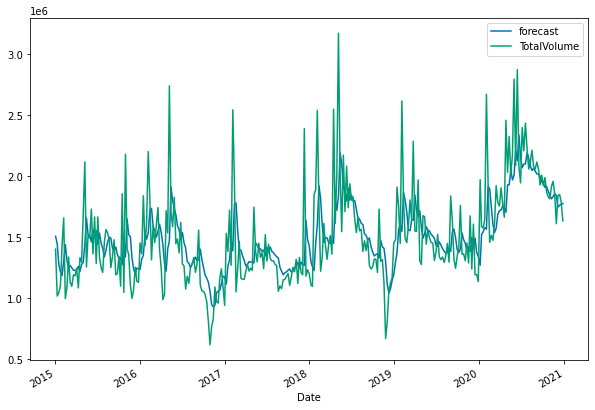

In [49]:
results_3.plot_predict(dynamic=False)
plt.show()

In [50]:
# MODEL EVALUATION 

In [51]:
Evaluation

{'mape': 0.17795015123427524,
 'me': -364651.61132869095,
 'mae': 371772.3085765432,
 'mpe': -0.17293557229195566,
 'rmse': 436066.1285370332,
 'corr': 0.7820283859682363,
 'minmax': 0.1777746198805038}

### model _4    ARMA_order=(8,0,0))  ------ARIMA   MONTHLY DATA

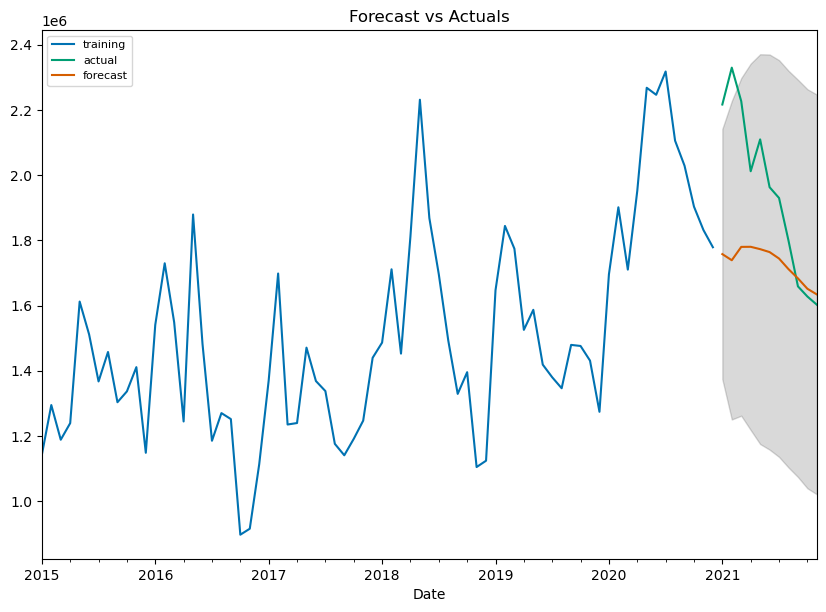

<Figure size 720x504 with 0 Axes>

In [52]:
Summary, Evaluation2, fc_series2, results_4, tr, tes, fc, conf= arima_sum_plot_pred(trainm, testm, 'TotalVolume', 8, 0, 0, 11)

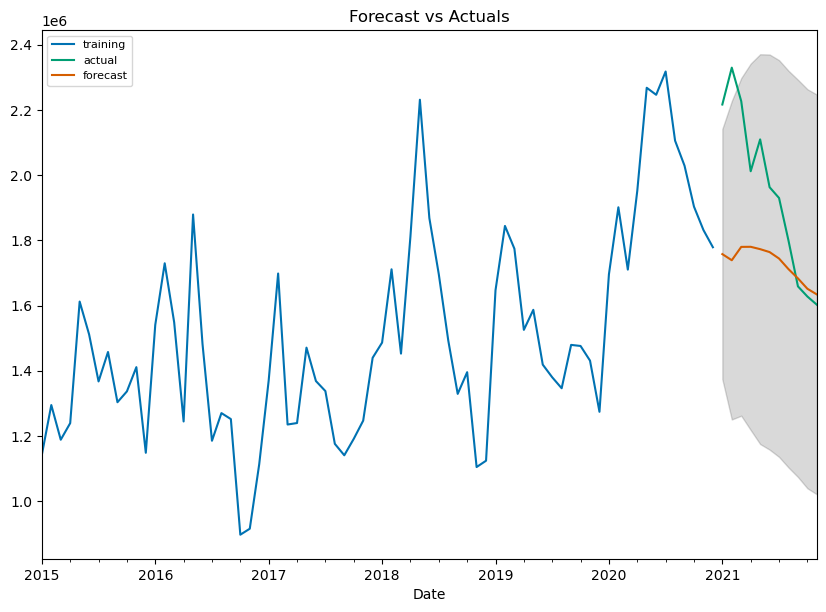

<Figure size 720x504 with 0 Axes>

In [53]:
Summary, Evaluation2, fc_series2, results_4, tr, tes, fc, conf= arima_sum_plot_pred(trainm, testm, 'TotalVolume', 8, 0, 0, 11)

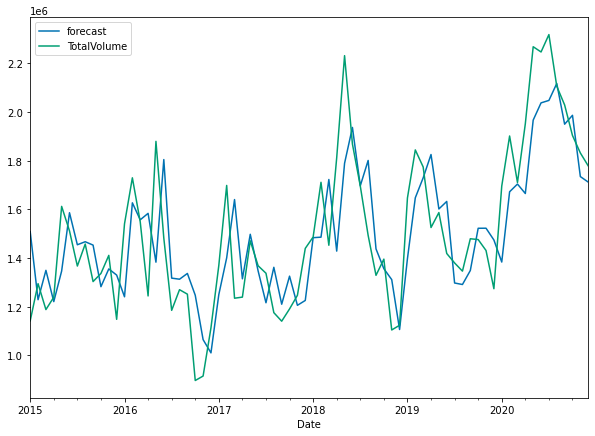

In [54]:
results_4.plot_predict(dynamic=False)
plt.show()

In [55]:
Evaluation2

{'mape': 0.11196081409031354,
 'me': -223441.36652925835,
 'mae': 237966.0274477089,
 'mpe': -0.10303352346411167,
 'rmse': 303116.595410309,
 'corr': 0.8271508756970604,
 'minmax': 0.111887506927287}

## Model_2 (ARMA order (8,0,1)   using SARIMAX (the best of dailydatset)

# Auto Arima Forecast with seasonal part 

In [56]:
#!pip install pmdarima (the best one that work for installation )

In [57]:
#model = pm.auto_arima(train[['TotalVolume']], 
#                     seasonal=True, m=52,
#                      d=0, D=0, 
#                      start_p=1, start_q=1,
#                      max_p=3, max_q=3,
#                     max_P=3, max_Q=3,
#                      trace=True,
#                      error_action='ignore',
#                      suppress_warnings=True,
#                      stepwise=True)

In [58]:
#Output------ daily dataset okkk

#Best model:  ARIMA(3,0,2)(3,0,1)[52] intercept
#Total fit time: 1275.397 seconds

In [59]:
#print(model.summary())

In [60]:
#model.plot_diagnostics()
#plt.show()

## Modeling with result from auto_arima / saisonal----daily data (also good)

In [61]:
def auto_arima(train, test, col, p,d,q,P,D,Q,s, steps, steps2):  
    # Create model object
    model_s = SARIMAX(train[[col]], 
                    order=(p,d,q), 
                    seasonal_order=(P,D,Q,s), 
                    trend='c')
    # Fit model
    results_s = model_s.fit()
    Summary = results_s.summary()
    diagnostic = results_s.plot_diagnostics()
    plt.show()
    # Create forecast object
    forecast_object_s = results_s.get_forecast(steps=steps) # step the same len as test set steps=96
    # Extract predicted mean attribute
    mean_s = forecast_object_s.predicted_mean
    
    evaluation = forecast_accuracy(mean_s, test[col].values)
    #......................................
    # Create forecast object
    forecast_object_s2 = results_s.get_forecast(steps=steps2) # steps=186
    # Extract predicted mean attribute
    mean_s2 = forecast_object_s2.predicted_mean
    
    return results_s, Summary, diagnostic, mean_s, mean_s2, evaluation

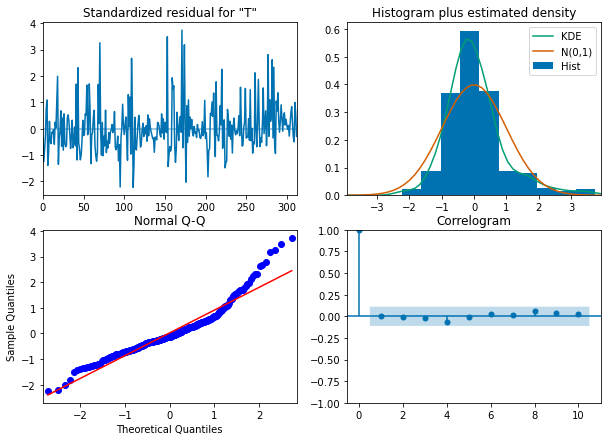

In [62]:
results_s, Summary, diagnostic, mean_1, mean_s2, evaluation = auto_arima(train, test, 'TotalVolume', 3,0,2,3,0,1,52, 48, 186)

In [63]:
type(test)

pandas.core.frame.DataFrame

In [64]:
mean_s2.head(5)

313    1.833558e+06
314    1.767039e+06
315    1.825938e+06
316    1.838134e+06
317    2.259986e+06
Name: predicted_mean, dtype: float64

In [65]:
evaluation

{'mape': 0.11000231048227797,
 'me': -213656.70919676745,
 'mae': 231941.1631314525,
 'mpe': -0.09828594696285407,
 'rmse': 305496.9833985542,
 'corr': 0.6247626989058378,
 'minmax': 0.1096307054422131}

## Modeling with result from auto_arima/saisonal ----montly data

In [66]:
#model = pm.auto_arima(trainm[['TotalVolume']], 
#                     seasonal=True, m=52,
#                      d=0, D=0, 
#                      start_p=1, start_q=1,
#                      max_p=3, max_q=3,
#                     max_P=3, max_Q=3,
#                      trace=True,
#                      error_action='ignore',
#                      suppress_warnings=True,
#                      stepwise=True)

In [67]:
#Best model:  ARIMA(1,0,0)(0,0,0)[52] intercept
#Total fit time: 2.391 seconds

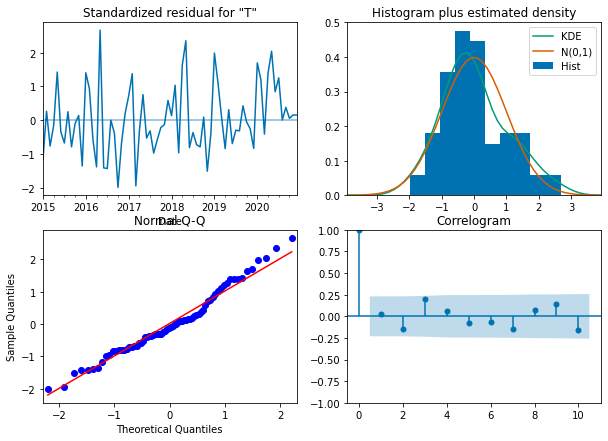

In [68]:
results_s2, Summary, diagnostic, mean_1, mean_s2, evaluation2 = auto_arima(trainm, testm, 'TotalVolume', 1,0,0,0,0,0,52, 11, 24)

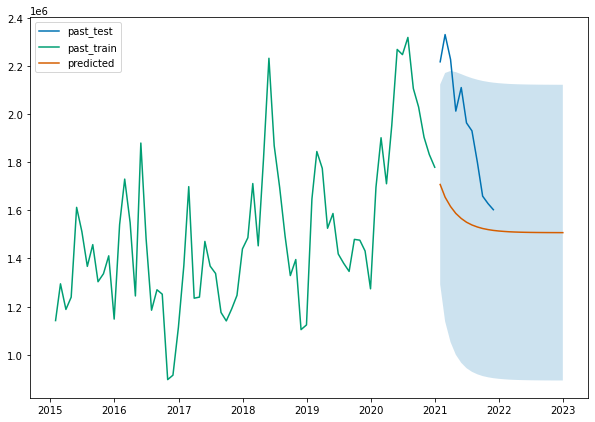

In [69]:
mean, dates, tes, tr, pred, conf, conf_int = plot_testm_trainm_pred(trainm, testm, 'TotalVolume', results_s2, steps=24)

In [70]:
get_model_eval(results_s2, testm, 'TotalVolume', 11)

{'mape': 0.10624450006915988,
 'me': -191532.39541898898,
 'mae': 224116.1650418425,
 'mpe': -0.08623354230205907,
 'rmse': 283305.085505037,
 'corr': 0.7596026839571477,
 'minmax': 0.10588875153864763}

In [71]:
evaluation2

{'mape': 0.18415798325563715,
 'me': -378599.32745406876,
 'mae': 378599.32745406876,
 'mpe': -0.18415798325563715,
 'rmse': 426120.8305967494,
 'corr': 0.8564741085216778,
 'minmax': 0.18415798325563726}

## check a model with exogenous variable Average Price

####  search for p,p,d -----------SARIMAX model

But for the sake of completeness, let’s try and force an external predictor, also called, ‘exogenous variable’ into the model. This model is called the SARIMAX model.

In [72]:
# SARIMAX Model
#modelexo = pm.auto_arima(train[['TotalVolume']], exogenous=train[['AveragePrice']],seasonal=True, m=52,
#                         d=0, D=0, 
#                      start_p=1, start_q=1,
#                      max_p=3, max_q=3,
#                      max_P=3, max_Q=3,
#                      trace=True,
#                      error_action='ignore',
#                      suppress_warnings=True,
#                      stepwise=True)
                        
#modelexo.summary()

In [73]:
# best with daily dataset
#Best model:  ARIMA(2,0,1)(3,0,0)[52]          
#Total fit time: 922.948 seconds

So, we have the model with the exogenous term. But the coefficient is very small for x1, so the contribution from that variable will be negligible. Let’s forecast it anyway.

# TheBest of daily forcast - seasonal (2,0,1)(3,0,0,52)

In [74]:
 def auto_arima_exo(train, test, col, col2, p,d,q,P,D,Q,s, steps, steps2):  
    # Create model object
    model_s = SARIMAX(train[[col]], exogenous=train[[col2]],
                order=(6,0,2),
                seasonal_order=(1,0,0,52), 
                trend='c')
    # Fit model
    results_s = model_s.fit()
    Summary = results_s.summary()
    diagnostic = results_s.plot_diagnostics()
    plt.show()
    # Create forecast object
    forecast_object_s = results_s.get_forecast(steps=steps) # step the same len as test set steps=96
    # Extract predicted mean attribute
    mean_s = forecast_object_s.predicted_mean
    
    evaluation = forecast_accuracy(mean_s, test[col].values)
    #......................................
    # Create forecast object
    forecast_object_s2 = results_s.get_forecast(steps=steps2) # steps=186
    # Extract predicted mean attribute
    mean_s2 = forecast_object_s2.predicted_mean
    
    return results_s, Summary, diagnostic, mean_s, mean_s2, evaluation

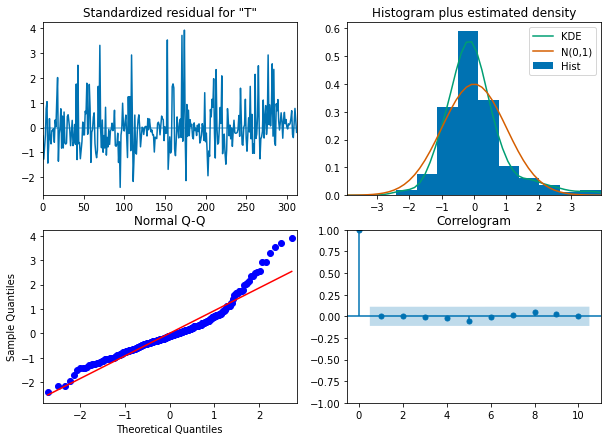

In [75]:
results_ex, Summary, diagnostic, mean_1, mean_s2, evaluation = auto_arima_exo(train, test, 'TotalVolume','AveragePrice', 2,0,1,3,0,0,52, 48, 186)

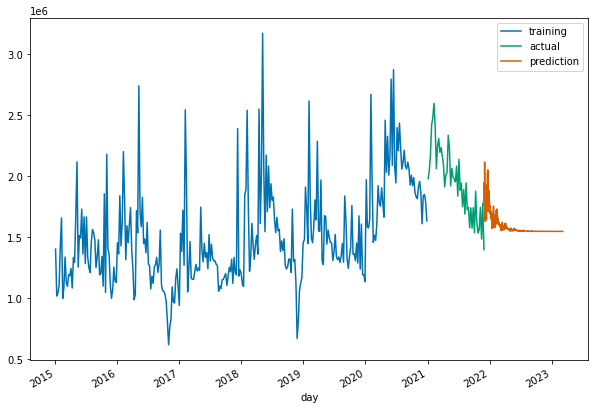

<Figure size 720x504 with 0 Axes>

In [76]:
mean, tr, tes, forday = forecast_day(train, test, results_ex, 'TotalVolume', 465, -1)   #steps=365

In [77]:
get_model_eval(results_s, test, 'TotalVolume', 48)

{'mape': 0.1624806563683134,
 'me': -329249.8963562679,
 'mae': 338152.62159014464,
 'mpe': -0.15626313886636636,
 'rmse': 394048.3926865055,
 'corr': 0.7932116632021867,
 'minmax': 0.16226338010502384}

## seasonal and exo  monthly forecaste

In [78]:
# SARIMAX Model
#modelexo = pm.auto_arima(trainm[['TotalVolume']], exogenous=trainm[['AveragePrice']],seasonal=True, m=52,
#                         d=0, D=0, 
#                      start_p=1, start_q=1,
#                      max_p=3, max_q=3,
#                      max_P=3, max_Q=3,
#                      trace=True,
#                      error_action='ignore',
#                      suppress_warnings=True,
#                     stepwise=True)
                                                 
#modelexo.summary()

In [79]:
# monthly dataset
#Best model:  ARIMA(1,0,0)(0,0,0)[52]          
#Total fit time: 4.153 seconds

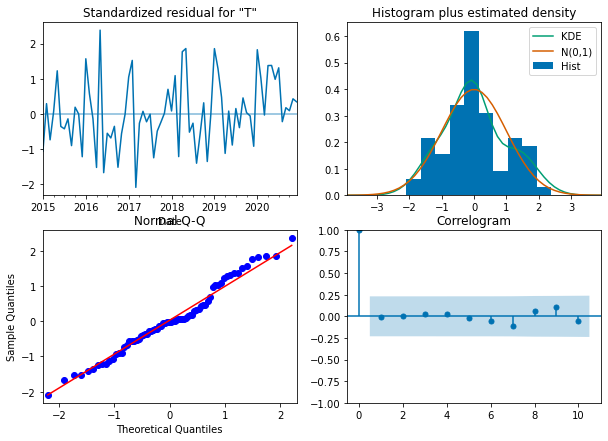

In [80]:
results_ex2, Summary, diagnostic, mean_1, mean_s2, evaluation2 = auto_arima_exo(trainm, testm,  'TotalVolume','AveragePrice', 1,0,0,0,0,0,52, 11, 24)

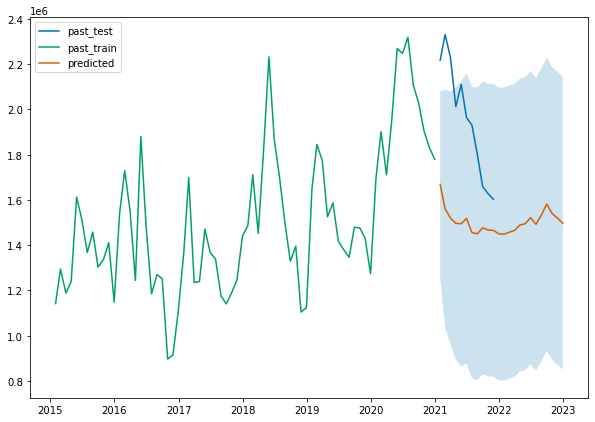

In [81]:
mean, dates, tes, tr, pred, conf, conf_int = plot_testm_trainm_pred(trainm, testm, 'TotalVolume', results_ex2, steps=24)

## Get all the models and compare

In [82]:
model = [results_3, results_4, results_1, results_2,  results_s, results_s2, results_ex, results_ex2]

In [83]:
# Accuracy metrics-----modify
def model_forecast_accuracy(forecast, actual):    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

def model_eval_sarimax(results, testm, col, steps):# len step equal len test size  (sarimax)(ok for montly and test )
    # Create forecast object
    forecast_object = results.get_forecast(steps=steps) # step the same len as test set 
    # Extract predicted mean attribute
    mean = forecast_object.predicted_mean
    # compute model evaluation 
    evaluation = model_forecast_accuracy(mean, testm[col].values)
    return evaluation

def model_eval_arima(results, test, col, steps):   #steps = 96
    # Forecast
    fc = results.forecast(steps, alpha=0.05)  # 95% conf
    # Make as pandas series
    fc_series = pd.Series(fc[0], index=test.index)
    # evaluation
    Evaluation = model_forecast_accuracy(fc_series, test[col].values)
    
    return Evaluation

In [84]:
monthly_model_sarimax = model_eval_sarimax(results_1, testm, 'TotalVolume', 11) # montly dataset
daily_model_sarimax = model_eval_sarimax(results_2, test, 'TotalVolume', 48) # daily dataset
daily_model_arima = model_eval_arima(results_3, test, 'TotalVolume', 48) # daily dataset
monthly_model_arima = model_eval_arima(results_4, testm, 'TotalVolume', 11) # montly dataset
daily_model_saisonal = model_eval_sarimax(results_s, test, 'TotalVolume', 48) # month dataset
monthly_model_saisonal = model_eval_sarimax(results_s2, testm, 'TotalVolume', 11) # day dataset
daily_model_exog = model_eval_sarimax(results_ex, test,'TotalVolume', 48) # day dataset
montly_model_exog = model_eval_sarimax(results_ex2, testm, 'TotalVolume', 11) # montly dataset

In [85]:
Name = [monthly_model_sarimax ,daily_model_sarimax,daily_model_arima,monthly_model_arima, daily_model_saisonal,monthly_model_saisonal,daily_model_exog ,montly_model_exog]
indexs = ['monthly_model_sarimax' ,'daily_model_sarimax','daily_model_arima','monthly_model_arima', 'daily_model_saisonal','monthly_model_saisonal','daily_model_exog' ,'montly_model_exog']

In [86]:
Model_Eval_con_volume = pd.DataFrame(Name, index= indexs)
Model_Eval_con_volume.sort_values('mape').round(3)*100

,mape,me,mae,mpe,rmse,corr
monthly_model_sarimax,10.6,-19153239.5,22411616.5,-8.6,28330508.6,76.0
daily_model_saisonal,11.0,-21365670.9,23194116.3,-9.8,30549698.3,62.5
monthly_model_arima,11.2,-22344136.7,23796602.7,-10.3,30311659.5,82.7
daily_model_exog,11.8,-18951193.9,24701748.5,-8.1,32250074.8,35.1
daily_model_arima,17.8,-36465161.1,37177230.9,-17.3,43606612.9,78.2
monthly_model_saisonal,18.4,-37859932.7,37859932.7,-18.4,42612083.1,85.6
daily_model_sarimax,20.2,-41525713.4,42088976.7,-19.8,48850547.6,56.6
montly_model_exog,21.9,-44597184.9,44597184.9,-21.9,49190222.4,68.4


In [87]:
# Save metrics results
datapath = './data'
save_file(Model_Eval_con_volume, 'Model_Eval_con_volume.csv', datapath)

Writing file.  "./data\Model_Eval_con_volume.csv"


In [88]:
Model_Eval_con_volume.to_excel("./data/Model_Eval_con_volume_excel.xlsx")

## forecast with the best Model and compare the change

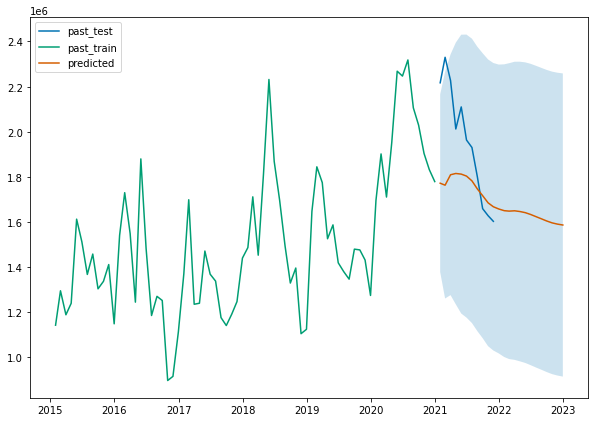

In [89]:
mean, dates, tes, tr, pred, conf, conf_int = plot_testm_trainm_pred(trainm, testm, 'TotalVolume', results_1, steps=24)

In [90]:
# save the prediction and test set 
conf_int['pred_mean_TotalVolume']= mean
conf_int['TotalVolume']= testm['TotalVolume']
conf_int.to_excel("./data/pred_con_volume_excel.xlsx")

<AxesSubplot:>

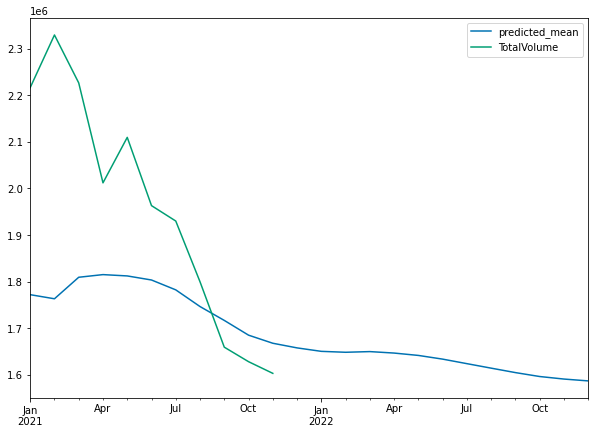

In [91]:
pred_price = mean.to_frame()
actual = testm['TotalVolume'].to_frame()
price_2021_2022 = pd.concat([pred_price, actual], axis=1)
price_2021_2022.plot()

In [92]:
# best for daily forecast volume

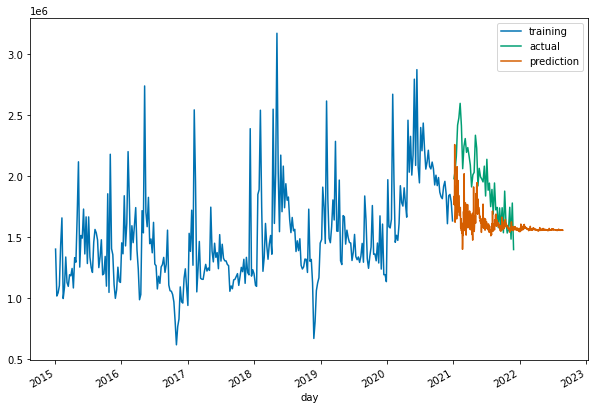

<Figure size 720x504 with 0 Axes>

In [93]:
mean2, tr, tes, forday = forecast_day(train, test, results_s, 'TotalVolume', 600, 0)   #steps=365

<AxesSubplot:>

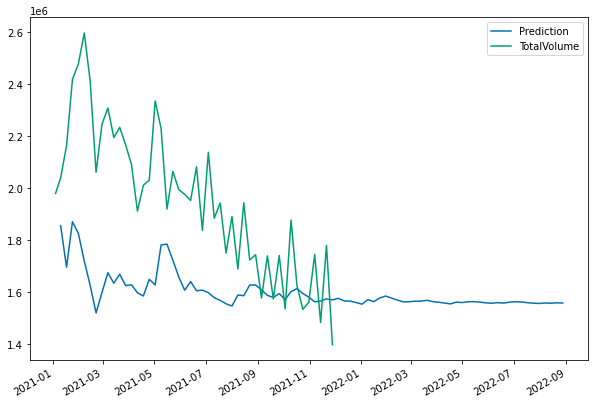

In [94]:
pred_price2 = mean2.resample('W').mean().dropna()
actual2 = test['TotalVolume'].to_frame()
price2_2021_2022 = pd.concat([pred_price2, actual2], axis=1)
price2_2021_2022.plot()

## Saving and updating models

In [95]:
#Import the joblib package and use it to save the model 
import joblib

# Set model name
filename = "Model_volume_con.pkl" # the best model with montly dataset 

# Pickle it
joblib.dump(results_1, filename)

# Load the model back in
#loaded_model = joblib.load(filename)
#Update the loaded model with the data df_new.
#loaded_model.update(df_new)

['Model_volume_con.pkl']